In [4]:
# unicarbkb -> epitope/rooted, linkage specific/non-specific
# import matlab
# import DrawGlycanSNFG
# dg=DrawGlycanSNFG.initialize()
# dg.drawglycan('Gal')


In [1]:
import pandas as pd
import numpy as np
import glypy
import json
import gc
import os

import subprocess
from glypy.io import glycoct

import glypy
from glycompare import *

execfile('annotated_iupac.py')


Thanks for using the GlyCompare v1.0, 
Please check our github for the latest update.


Bokan & Ben,
08/1/2019


Parsing 'a-D-Manp{arbitrary=true;json_valued=[1,2,3,4];annotations="here"}'
(RES 1b:a-dman-HEX-1:5, {'json_valued': [1, 2, 3, 4], 'annotations': u'here', 'arbitrary': True})


Annotating N-Linked Core
a-D-Manp{terminal=true}-(1-6)-[a-D-Manp{terminal=true}-(1-3)]b-D-Manp-(1-4)-b-D-Glcp2NAc-(1-4)-b-D-Glcp2NAc


In [2]:

###############################3
#### input
############3
re_download = False
custom_vectors = True
root_dir = os.getcwd() #'/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/GTspecificity/'
organism = 'human'
#init.extact_Ture = False ## if all the input glycans are linkage specified change to true

#in
unicarbURL = 'https://data.glygen.org/datasets/reviewed/'+organism+'_proteoform_glycosylation_sites_unicarbkb_glytoucan.csv'
glytoucanURL = 'https://data.glygen.org/datasets/reviewed/'+organism+'_glycan_sequences.csv'
unicarbGitLab = '/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/GTspecificity/Unicarb-Glygen/data_files/unicarbkb/DATA_RELEASE/STABLE/'+organism+'.csv'
unicarb_file = root_dir+'/annotation/01_webscrape/unicarb.in.csv'
glytoucan_file = root_dir+'/annotation/01_webscrape/glytoucan.in.csv'
motif_vector_filename = '/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/GlyCompare/generated_json_file/Unicarbkb_motif_vec_12259.json'

#out
glytoucan_motif_file = root_dir+'annotation/01_webscrape/glytoucan_motif.out.csv'
uncarb_glytoucan_motif_file = root_dir+'annotation/01_webscrape/unicarb_glytoucan_motif.out.csv'
#motif_vector_all_local = 'annotation/01_webscrape/glytoucan_motif_ALL.out.json'
#motif_vector_local = 'annotation/01_webscrape/glytoucan_motif_vec.out.json'
##########################

##### (Down)load Unicarb & Glytoucan
print('(Down)load Unicarb & Glytoucan')
if re_download:
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    unicarb = pd.read_csv(unicarbURL).drop_duplicates()
    #unicarb.to_csv(unicarb_file)
    unicarb2 = pd.read_csv(unicarbGitLab).drop_duplicates()

    # convert gitlab to unicarb-glygen format
    resnum = []
    for i in unicarb2.Position:
        ii = i.replace('^^xsd:int','')
        if ii=='':
            resnum.append(0)
        else:
            resnum.append(ii)

    unicarb = pd.DataFrame({'uniprotkb_acc_canonical':unicarb2.identifer,
                           'glycosylation_site':resnum,
                           'evidence':unicarb2.Pmid,
                           'uckb_id':unicarb2.Id,
                           'glytoucan_acc':unicarb2.Toucan,
                           'amino_acid':unicarb2.TypeAminoAcid})
    unicarb.to_csv(unicarb_file)

    glytoucan = pd.read_csv(glytoucanURL)
    glytoucan = glytoucan.loc[glytoucan.glytoucan_acc.isin(unicarb.glytoucan_acc)] # remove glycans not appearing in unicarb
    glytoucan = glytoucan.dropna() # drop na
    glytoucan.to_csv(glytoucan_file)
else:
    unicarb = pd.read_csv(unicarb_file).drop_duplicates()
    glytoucan = pd.read_csv(glytoucan_file)

(Down)load Unicarb & Glytoucan


In [21]:
# print(unicarb.shape)
# print(glytoucan.shape)

# df = pd.merge(unicarb,glytoucan,on='glytoucan_acc',how='left')

# print(df.shape)

# df=df[~df.uckb_id.str.contains("comp_")]

# print(df.shape)

# df.to_csv('/home/ben/Downloads/glytoucan_unicarb.csv')

# #print(df.head())

# #df.linearcode = 
# #[io.linearcode.dumps(glypy.io.glycoct.load(g)) for g in df.glycoct]

# ### save for james and albert
# # remove compositional data
# #df[~df.uckb_id.str.contains("comp_")].head()
# # merge glytoucan and unicarb
# # get linear code
# # save

In [4]:
unicarb.head()

,Unnamed: 0,amino_acid,evidence,glycosylation_site,glytoucan_acc,uckb_id,uniprotkb_acc_canonical
0,0,Asn,24841998,453,NaN,comp_HexNAc4Hex5dHex0NeuAc2NeuGc0Pent0S0P0KDN0...,P02790
1,1,Asn,29741879,869,NaN,comp_HexNAc0Hex0dHex0NeuAc0NeuGc0Pent0S0P0KDN0...,Q9Y4L1
2,2,Asn,29741879,515,NaN,comp_HexNAc0Hex0dHex0NeuAc0NeuGc0Pent0S0P0KDN0...,Q9Y4L1
3,3,Asn,29741879,515,NaN,comp_HexNAc3Hex4dHex3NeuAc0NeuGc0Pent0S0P0KDN0...,Q9Y4L1
4,4,Asn,29741879,515,NaN,comp_HexNAc4Hex3dHex0NeuAc2NeuGc0Pent0S0P0KDN0...,Q9Y4L1


In [5]:
glytoucan.head()

,Unnamed: 0,glytoucan_acc,iupac_extended,glycoct,wurcs
0,4,G10609HO,?-D-Manp-(1->?)[?-D-Manp-(1->?)]-alpha-D-Manp-...,RES 1b:b-dglc-HEX-1:5 2s:n-acetyl 3b:b-dglc-HE...,"WURCS=2.0/4,8,7/[a2122h-1b_1-5_2*NCC/3=O][a112..."
1,7,G33734YD,beta-D-Galp-(1->4)-beta-D-GlcpNAc-(1->4)-alpha...,RES 1b:b-dglc-HEX-1:5 2s:n-acetyl 3b:b-dglc-HE...,"WURCS=2.0/5,8,7/[a2122h-1b_1-5_2*NCC/3=O][a112..."
2,20,G71919QK,"beta-D-Galp-(1->4)-beta-D-GlcpNAc-(1->3),beta-...",RES 1b:b-dglc-HEX-1:5 2s:n-acetyl 3b:b-dglc-HE...,"WURCS=2.0/5,16,15/[a2122h-1b_1-5_2*NCC/3=O][a1..."
3,27,G97765TT,alpha-D-GalpNAc-(1->3)[alpha-L-Fucp-(1->2)]-be...,RES 1b:b-dglc-HEX-1:5 2s:n-acetyl 3b:b-dglc-HE...,"WURCS=2.0/6,12,11/[a2122h-1b_1-5_2*NCC/3=O][a1..."
4,38,G84852GW,alpha-D-NeupAc-(2->6)-beta-D-Galp-(1->4)-beta-...,RES 1b:b-dglc-HEX-1:5 2s:n-acetyl 3b:b-dglc-HE...,"WURCS=2.0/6,9,8/[a2122h-1b_1-5_2*NCC/3=O][a112..."


(RES 1b:b-dglc-HEX-1:5 2s:n-acetyl LIN 1:1d(2+1)2n: id=1  x=6.123233995736766e-17 mod=0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f602ce38c10>)

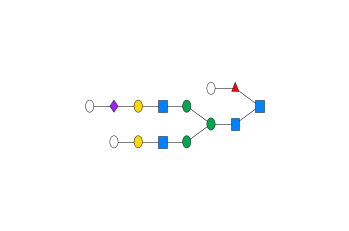

In [70]:
# tmp = unicarb.merge(glytoucan,'left')
# tmp[tmp.glytoucan_acc!='NaN'].head()
#[i in unicarb.glytoucan_acc for i in glytoucan.glytoucan_acc]

ags = glypy.io.iupac.GlycanSerializer(AnnotatedMonosaccharideSerializer())
agd = glypy.io.iupac.GlycanDeserializer(AnnotatedMonosaccharideDeserializer())

#ex=agd(ags(glypy.io.iupac.loads(glypy.io.iupac.dumps(glycan_dict['G83461WR']))))
#ex=agd(ags(glycan_dict['G83461WR']))
ex =glycan_dict['G83461WR']
# ex[4].annotations['terminal'] = True
# print ex[4].annotations 

terminus="x-SUG-0:0"
for i in ex.indexed_traversal():
    if len(i.children())==0:
        i.add_monosaccharide( glypy.monosaccharides.Sug)
        
glypy.plot.plot(ex)
#  # iterate over glycan fragments
# for i in ex.fragments(max_cleavages=4):
#     # print('aaa')
#     _frag_gly = agd(ags(glypy.structure.glycan.fragment_to_substructure(i, ex)))
#     print _frag_gly

In [71]:
def add_terminus(g):
    for i in g.indexed_traversal():
        if len(i.children())==0:
            i.add_monosaccharide( glypy.monosaccharides.Sug)
    return g

In [72]:
# init glycan dictionary
glycan_dict={gi:glycoct.loads(cti) for gi,cti in zip(glytoucan.glytoucan_acc,glytoucan.glycoct)}
#glycan_dict={gi:add_terminus(glycoct.loads(cti)) for gi,cti in zip(glytoucan.glytoucan_acc,glytoucan.glycoct)}

In [74]:
# extract substructures
glycan_substructure_dic = extract_substructures.extract_substructures_pip(glycan_dict=glycan_dict,
        gly_len=50,num_processors=15,
        output_file='annotation/01_webscrape/unicarb_glytoucan_substructures.complete.json')
#        output_file='annotation/01_webscrape/unicarb_glytoucan_substructures.complete.terminus.json')

('start parallel parsing', 562, 'glycans')
('start', 'G74838NI')
('start', 'G00281HB')
('start', 'G83461WR')
('start', 'G64973KT')
('start', 'G97720QM')
('start', 'G57789QC')
('start', 'G33734YD')
('start', 'G16536EO')
('start', 'G33608TH')
('start', 'G27844UM')
('start', 'G96719MC')
('start', 'G42264OV')
('start', 'G53450AF')
('start', 'G20030CU')
('start', 'G03275SD')
('start', 'G03081ER')
('start', 'G89993FE')
('start', 'G38586WN')
('start', 'G99808VS')
('start', 'G71919QK')
('start', 'G40194MN')
('start', 'G61937QU')
('start', 'G30048DT')
('start', 'G75303RX')
('start', 'G89738LW')
('start', 'G98535LH')
('start', 'G36134VO')
('start', 'G25837HW')
('start', 'G51941GC')
('start', 'G15407YE')
('start', 'G68892PJ')
('start', 'G41304KE')
('start', 'G46748BU')
('start', 'G11994QC')
('start', 'G80858MF')
('start', 'G23484GM')
('start', 'G67393WG')
('start', 'G16529MG')
('start', 'G97765TT')
('start', 'G23695IQ')
('start', 'G38756OC')
('start', 'G44444MB')
('start', 'G04791QM')
('start', '

IndexError: list index out of range

('start', 'G87618BG')
('start', 'G03984TW')
('start', 'G37320GX')
('start', 'G46754UW')
('start', 'G84390MS')
('start', 'G43694RQ')
('start', 'G43648DB')
('start', 'G03216SJ')
('start', 'G56903ZB')
('start', 'G87633UQ')
('start', 'G61726TP')
('start', 'G56501FP')
('start', 'G44413JJ')
('start', 'G06601SQ')
('start', 'G24440EI')
('start', 'G14358WN')
('start', 'G39540XG')
('start', 'G61170KL')
('start', 'G12222NC')
('start', 'G75850OP')
('start', 'G14176QY')
('start', 'G53276NK')
('start', 'G63640QH')
('start', 'G80678MA')
('start', 'G92534LG')
('start', 'G51369CD')
('start', 'G57835AK')
('start', 'G60230HH')
('start', 'G25350TT')
('start', 'G89877QI')
('start', 'G20966IA')
('start', 'G83006TR')
('start', 'G33241WC')
('start', 'G47108UC')
('start', 'G91905FJ')
('start', 'G52622SW')
('start', 'G75903TQ')
('start', 'G13290KJ')
('start', 'G59361OW')
('start', 'G98455QP')
('start', 'G57413FT')
('start', 'G24413UY')
('start', 'G75269BP')
('start', 'G82348BZ')
('start', 'G16546ZZ')
('start', 

In [14]:
# merge substructures
merge_substructure_dict_linkSpecific = merge_substructure_vec.merge_substructure_dict_pip(
            glycan_substructure_dict=glycan_substructure_dic,glycan_dict=glycan_dict,
            linkage_specific=True,num_processors=40,
            output_merged_substructure_glycoct_dict_addr='annotation/01_webscrape/unicarb_substructures.linkSpecific.merged.json')

merge_substructure_dict_linkAmbig = merge_substructure_vec.merge_substructure_dict_pip(
            glycan_substructure_dict=glycan_substructure_dic,glycan_dict=glycan_dict,
            linkage_specific=False,num_processors=40,
            output_merged_substructure_glycoct_dict_addr='annotation/01_webscrape/unicarb_substructures.linkAmbiguous.merged.json')


Start merge_glycan_substructure_to_substructure_dict
combine original
add new glycan degree
substructure_dict is merged with len  158374
finished removing duplicate
after the cleaning the substructure vec's length is 26962
1 19
2 65
3 209
4 411
5 703
6 1167
7 1772
8 2365
9 2812
10 3087
11 3157
12 3026
13 2619
14 1987
15 1422
16 950
17 615
18 333
19 167
20 60
21 13
22 1
24 2
26962
Start merge_glycan_substructure_to_substructure_dict
combine original
add new glycan degree
substructure_dict is merged with len  158374
finished removing duplicate
after the cleaning the substructure vec's length is 10142
1 16
2 33
3 80
4 156
5 249
6 385
7 574
8 791
9 991
10 1120
11 1216
12 1219
13 1112
14 868
15 597
16 366
17 198
18 100
19 45
20 19
21 5
22 1
24 1
10142


In [15]:
gc.collect()

2371650

In [16]:
#merge_substructure_dict_linkSpecific = glycan_io.load_glycan_substructure_dict_from_json(json_utility.load_json('annotation/01_webscrape/unicarb_substructures.linkSpecific.merged.json'))
#merge_substructure_dict_linkAmbig = glycan_io.load_glycan_substructure_dict_from_json(json_utility.load_json('annotation/01_webscrape/unicarb_substructures.linkAmbiguous.merged.json'))


In [17]:
# match substructures

#glycan_substructure_dic = glycan_io.load_glycan_substructure_dict_from_json('annotation/01_webscrape/unicarb_glytoucan_substructures.complete.json')


matched_dict_linkSpecific = merge_substructure_vec.substructure_matching_wrapper(substructure_=merge_substructure_dict_linkSpecific,
                    glycan_substructure_dict=glycan_substructure_dic,
                    linkage_specific=True,
                    num_processors=40,
                    matched_dict_addr='annotation/01_webscrape/unicarb_substructures.linkSpecific.matched.json')
gc.collect()


matched_dict_linkAmbig = merge_substructure_vec.substructure_matching_wrapper(substructure_=merge_substructure_dict_linkAmbig,
                    glycan_substructure_dict=glycan_substructure_dic,
                    linkage_specific=False,
                    num_processors=40,
                    matched_dict_addr='annotation/01_webscrape/unicarb_substructures.linkAmbiguous.matched.json')


1 19
2 65
3 209
4 411
5 703
6 1167
7 1772
8 2365
9 2812
10 3087
11 3157
12 3026
13 2619
14 1987
15 1422
16 950
17 615
18 333
19 167
20 60
21 13
22 1
24 2
26962
get substructure vec, the length is  26962
start processing G56682BC
start processing G65562ZE
start processing G53168IY
start processing G33734YD
start processing G10609HO
start processing G63640QH
start processing G84852GW
start processing G58667NI
start processing G59576IJ
start processing G90987JA
start processing G83161QT
start processing G38586WN
start processing G25835MT
start processing G48381WH
start processing G14343MU
start processing G45187EI
start processing G22493AJ
start processing G10258MC
start processing G47606XQ
start processing G76012OT
start processing G71367OV
start processing G97765TT
start processing G82348BZ
start processing G42797SX
start processing G24413UY
start processing G28156XV
start processing G25350TT
start processing G44444MB
start processing G94435QH
start processing G56749GV
start processing 

In [ ]:
# get heirarchy

nglycan_core = """
RES
1b:x-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:a-dman-HEX-1:5
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:5o(6+1)7d """

merge_substructure_dict_linkSpecific = glycan_io.load_substructure_vec_from_json('annotation/01_webscrape/unicarb_substructures.linkSpecific.merged.json')
merge_substructure_dict_linkAmbig = glycan_io.load_substructure_vec_from_json('annotation/01_webscrape/unicarb_substructures.linkAmbiguous.merged.json')


# rooted & linkage specific
substructureLab_nglyRoot_linkSpecific = select_motifs.substructureLabwithCore(substructure_=merge_substructure_dict_linkSpecific,
                                            glycan_core=nglycan_core,
                                            linkage_specific=True) 
substructureLab_nglyRoot_linkSpecific.get_dependence_tree_core()

# rooted & linkage specific
substructureLab_nglyRoot_linkAmbig = select_motifs.substructureLabwithCore(substructure_=merge_substructure_dict_linkAmbig,
                                            glycan_core=nglycan_core,
                                            linkage_specific=False) 
substructureLab_nglyRoot_linkAmbig.get_dependence_tree_core()

# no-rooted & linkage specific
substructureLab_noRoot_linkSpecific = select_motifs.substructureLab(substructure_=merge_substructure_dict_linkSpecific,
                                            linkage_specific=True) 
substructureLab_noRoot_linkSpecific.get_dependence_tree_all()

# no-rooted & linkage specific
substructureLab_noRoot_linkAmbig = select_motifs.substructureLab(substructure_=merge_substructure_dict_linkAmbig,
                                            linkage_specific=False) 
substructureLab_noRoot_linkAmbig.get_dependence_tree_all()


the glycan core is
start substructure_with core
len 5
len 6
len 7
len 8
len 9
len 10
len 11
len 12
len 13
len 14
len 15
len 16
len 17
len 18
len 19
len 20
len 21
len 22
len 24
Finish the n-glycan match  12940  substructures are matched to the n-glycan core
start building dependence_tree
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
24
the glycan core is
start substructure_with core
len 5
len 6
len 7
len 8
len 9
len 10
len 11
len 12
len 13
len 14
len 15
len 16
len 17
len 18
len 19
len 20
len 21
len 22
len 24
Finish the n-glycan match  5223  substructures are matched to the n-glycan core
start building dependence_tree
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
24
start building dependence_tree
1
2
3
4
5
6
7
8
9
10
11
12
13


In [32]:
# save dependency trees
import json

with open('annotation/01_webscrape/unicarb_substructures.linkSpecific.nglyroot_heirarchy.json', 'w') as fp:
    json.dump(substructureLab_nglyRoot_linkSpecific.substructure_dep_tree_core, fp)
    
with open('annotation/01_webscrape/unicarb_substructures.linkAmbiguous.nglyroot_heirarchy.json', 'w') as fp:
    json.dump(substructureLab_nglyRoot_linkAmbig.substructure_dep_tree_core, fp)
    
with open('annotation/01_webscrape/unicarb_substructures.linkSpecific.unrooted_heirarchy.json', 'w') as fp:
    json.dump(substructureLab_noRoot_linkSpecific.substructure_dep_tree, fp)
    
with open('annotation/01_webscrape/unicarb_substructures.linkAmbiguous.unrooted_heirarchy.json', 'w') as fp:
    json.dump(substructureLab_noRoot_linkAmbig.substructure_dep_tree, fp)
